In [ ]:
import anndata
import xarray as xr
import pandas as pd
import numpy as np
from dask import delayed, compute
from glob import glob

# Assume all .h5ad files are in a directory
file_list = glob(r"D:\Mouse\Matrices\*.h5ad")

# Determine the union of parcellation indices and subclasses (for Isocortex cells)
all_parcellation_indices = set()
all_subclasses = set()

for f in file_list:
    adata = anndata.read_h5ad(f, backed='r')
    # Filter for cells with parcellation_division == 'Isocortex.'
    mask = adata.obs['parcellation_division'] == 'Isocortex'
    # Use the filtered view for the union
    adata_filtered = adata[mask, :]
    all_parcellation_indices.update(adata_filtered.obs['parcellation_index'].unique())
    all_subclasses.update(adata_filtered.obs['subclass'].unique())

all_parcellation_indices = sorted(list(all_parcellation_indices))
all_subclasses = sorted(list(all_subclasses))
print(f'processed {len(file_list)} files')

# Assume gene symbols are the same in all files; load from the first file
adata = anndata.read_h5ad(file_list[0], backed='r')
gene_symbols = adata.var_names.tolist()
n_genes = len(gene_symbols)
print(f"Loaded gene symbols with length {len(gene_symbols)}")


processed 53 files
Loaded gene symbols with length 8460


In [2]:
import os

def process_file_in_chunks_update(file_path, agg_file, gene_symbols, union_parcellation_indices, union_subclasses, chunk_size=500):
    """
    Process one h5ad file in chunks and update an aggregated .nc file on disk.
    The aggregated file stores cumulative sum and count arrays so that the overall
    mean expression can be computed correctly.
    
    Parameters:
      file_path: path to the h5ad file.
      agg_file: path to the aggregated NetCDF file.
      gene_symbols: list/array of gene symbols.
      union_parcellation_indices: list of all parcellation indices.
      union_subclasses: list of all subclasses.
      chunk_size: number of cells to process at a time.
      
    The function updates (or creates) the aggregated file by reading the current cumulative
    sum and count arrays, adding the new file's contributions, and saving the updated arrays.
    """
    # Determine the number of genes.
    n_genes = len(gene_symbols)
    n_parc = len(union_parcellation_indices)
    n_sub = len(union_subclasses)
    
    # Preallocate arrays for this file's sums and counts.
    sum_array = np.zeros((n_genes, n_parc, n_sub), dtype=np.float64)
    count_array = np.zeros((n_genes, n_parc, n_sub), dtype=np.int64)
    
    # Open the file in backed mode.
    adata = anndata.read_h5ad(file_path, backed='r')
    n_cells = adata.n_obs

    for start in range(0, n_cells, chunk_size):
        end = min(start + chunk_size, n_cells)
        # Load chunk into memory.
        chunk = adata[start:end, :].to_memory()
        
        # Filter for Isocortex cells.
        mask = chunk.obs['parcellation_division'] == 'Isocortex'
        if mask.sum() == 0:
            continue
        chunk_filt = chunk[mask, :]
        expr_data = chunk_filt.X
        
        # Create a DataFrame for this chunk using gene_symbols as columns.
        df = pd.DataFrame(expr_data, index=chunk_filt.obs_names, columns=gene_symbols)
        df["subclass"] = chunk_filt.obs["subclass"].values
        df["parcellation_index"] = chunk_filt.obs["parcellation_index"].values
        
        # Group by subclass and parcellation_index and compute sum.
        grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
        # Compute counts for each group.
        grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
        
        # Loop through groups in this chunk and update the file-level arrays.
        for (subclass, parc_idx), gene_sum in grouped_sum.iterrows():
            try:
                p_idx = union_parcellation_indices.index(parc_idx)
                c_idx = union_subclasses.index(subclass)
            except ValueError:
                continue  # Skip if the label is not in our union.
            # Add the gene expression sum.
            sum_array[:, p_idx, c_idx] += gene_sum.values
            # The count is the same for all genes in this group.
            count_array[:, p_idx, c_idx] += grouped_count.loc[(subclass, parc_idx)]
    
    adata.file.close()  # Close the h5ad file.

    # Now update (or create) the aggregated file on disk.
    if os.path.exists(agg_file):
        ds_agg = xr.load_dataset(agg_file)
        cumulative_sum = ds_agg['sum'].values
        cumulative_count = ds_agg['count'].values
    else:
        cumulative_sum = np.zeros((n_genes, n_parc, n_sub), dtype=np.float64)
        cumulative_count = np.zeros((n_genes, n_parc, n_sub), dtype=np.int64)
    
    # Update cumulative arrays.
    cumulative_sum += sum_array
    cumulative_count += count_array
    
    # Compute the overall mean; avoid division by zero.
    mean_array = np.full((n_genes, n_parc, n_sub), np.nan, dtype=np.float64)
    valid = cumulative_count > 0
    mean_array[valid] = cumulative_sum[valid] / cumulative_count[valid]
    
    # Create an xarray Dataset with the cumulative arrays.
    ds_out = xr.Dataset({
        "sum": (["gene_symbol", "parcellation_index", "subclass"], cumulative_sum),
        "count": (["gene_symbol", "parcellation_index", "subclass"], cumulative_count),
        "mean": (["gene_symbol", "parcellation_index", "subclass"], mean_array)
    },
    coords={
        "gene_symbol": gene_symbols,
        "parcellation_index": union_parcellation_indices,
        "subclass": union_subclasses
    })
    
    # Save the updated aggregated dataset back to disk.
    ds_out.to_netcdf(agg_file)
    print(f"Updated aggregated file: {agg_file}")


agg_file_path = r"aggregated_data.nc"
# Process each file and update the aggregated NetCDF file.
for file_path in file_list:
    print(f"Processing {file_path}...")
    process_file_in_chunks_update(file_path, agg_file_path, gene_symbols, all_parcellation_indices, all_subclasses, chunk_size=500)


Processing D:\Mouse\Matrices\C57BL6J-638850.05.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.06.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.08.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.09.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.10.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.11.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.12.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.13.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.14.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.15.h5ad...
Updated aggregated file: aggregated_data.nc
Processing

C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.19.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.24.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.25.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.26.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.27.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.28.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.29.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.30.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.31.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.32.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.33.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.35.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.36.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.37.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.38.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.39.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.40.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.42.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.43.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.44.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.45.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.46.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.47.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.48.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.49.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.50.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.51.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.52.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.54.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.55.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.56.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.57.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.58.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.59.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.60.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.61.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.62.h5ad...


C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).sum()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df[gene_symbols].groupby([df["subclass"], df["parcellation_index"]]).size()
C:\Users\fjpgr\AppData\Local\Temp\ipykernel_1088\256308034.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.64.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.66.h5ad...
Updated aggregated file: aggregated_data.nc
Processing D:\Mouse\Matrices\C57BL6J-638850.67.h5ad...
Updated aggregated file: aggregated_data.nc


Found 62 cells for parcellation index 1230
Found 62 cells in the expression data
Found 77 cells for parcellation index 1232
Found 77 cells in the expression data
Found 128 cells for parcellation index 417
Found 128 cells in the expression data
Found 228 cells for parcellation index 878
Found 228 cells in the expression data
Found 83 cells for parcellation index 978
Found 83 cells in the expression data
Found 82 cells for parcellation index 682
Found 82 cells in the expression data
Found 2 cells for parcellation index 1090
Found 2 cells in the expression data
Found 12 cells for parcellation index 227
Found 12 cells in the expression data
Found 18 cells for parcellation index 279
Found 18 cells in the expression data
Found 14 cells for parcellation index 158
Found 14 cells in the expression data
Found 73 cells for parcellation index 530
Found 73 cells in the expression data
Found 15 cells for parcellation index 826
Found 15 cells in the expression data
Found 9 cells for parcellation inde

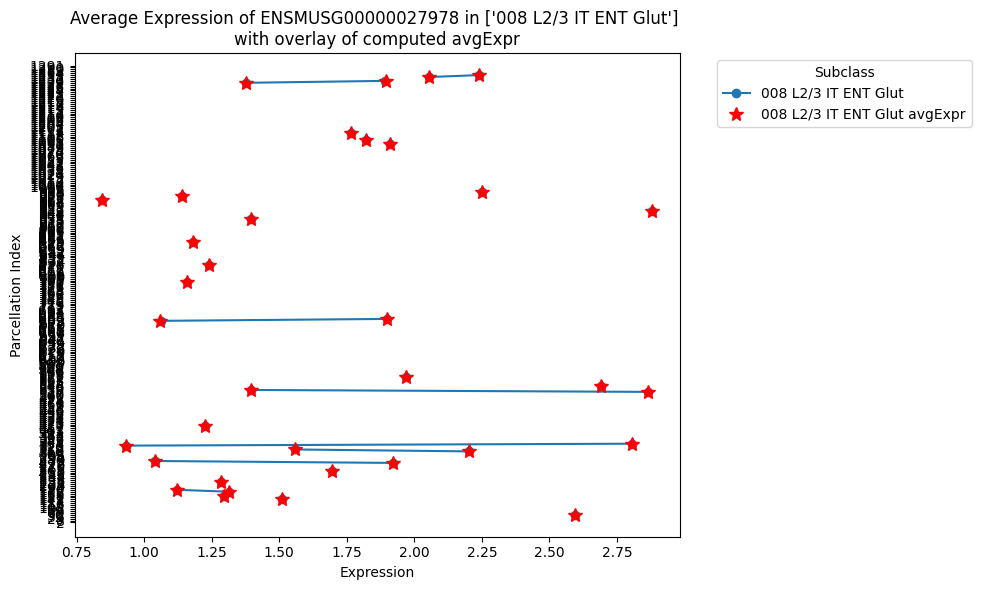

In [7]:
import matplotlib.pyplot as plt

# -----------------------
# First Code: Compute avgExpr for the specific cell type
# -----------------------

# Load cell metadata
metadata = pd.read_csv(
    r"D:\Mouse\GeneExpressions\metadata\MERFISH-C57BL6J-638850-CCF\20231215\views\cell_metadata_with_parcellation_annotation.csv",
    usecols=['cell_label','subclass','parcellation_index', 'parcellation_division']
)

gene = 'ENSMUSG00000027978'
cellType = '008 L2/3 IT ENT Glut'

# Filter for Isocortex and the desired subclass
metadataIsocortex = metadata[metadata['parcellation_division'] == 'Isocortex']
metadataIsocortexSubclass = metadataIsocortex[metadataIsocortex['subclass'] == cellType]

# Get unique parcellation indices for the cell type
subset_parcellation_indices = metadataIsocortexSubclass['parcellation_index'].unique()

# Set the index to 'cell_label' so it matches exprData.obs_names
metadataIso_indexed = metadataIsocortexSubclass.set_index('cell_label')

# Load the expression data
geneImputedExpression = r"D:\Mouse\GeneExpressions\expression_matrices\MERFISH-C57BL6J-638850-imputed\20240831\C57BL6J-638850-imputed-log2.h5ad"
exprData = anndata.read_h5ad(geneImputedExpression, backed='r')

# Compute average expression for each parcellation index in the subset
avgExpr = {}  # use a dictionary: key = parcellation index, value = avg expression
for PI in subset_parcellation_indices:
    # Get cell labels for current parcellation index
    cellsPI = metadataIsocortexSubclass[metadataIsocortexSubclass['parcellation_index'] == PI]['cell_label'].tolist()
    print(f"Found {len(cellsPI)} cells for parcellation index {PI}")
    
    # Find the intersection between these cell labels and the AnnData obs_names
    cellsExpr = exprData.obs_names.intersection(cellsPI)
    print(f"Found {len(cellsExpr)} cells in the expression data")
    
    # Get the expression data for the gene for these cells
    if gene in exprData.var_names:
        gene_data = exprData[cellsExpr, gene].X

        # Compute average expression for this parcellation index
        avg_gene_data = gene_data.mean()
        avgExpr[PI] = avg_gene_data
    else:
        print(f"Gene {gene} not found in the expression data.")

# -----------------------
# Second Code: Plot full data and overlay avgExpr
# -----------------------

# Open the final data array from the xarray file
ds = xr.open_dataset("aggregated_data.nc")
gene_data = ds["mean"].sel(gene_symbol=gene)

# Get the full set of parcellation indices and subclasses from the xarray data
full_PI = gene_data.parcellation_index.values
all_subclasses = gene_data.subclass.values

plt.figure(figsize=(10, 6))
selected_subclasses = [cellType]

# Plot the full data for the selected subclass
for subclass in selected_subclasses:
    if subclass in all_subclasses:
        expr_values = gene_data.sel(subclass=subclass).values
        # Plot the gene expression for the subclass
        plt.plot(expr_values, range(len(full_PI)), marker='o', label=str(subclass))
    else:
        print(f"Warning: Subclass {subclass} not found in the data.")

# Create a mapping from parcellation index (as in the full xarray data) to its y-axis position
pi_to_y = {pi: idx for idx, pi in enumerate(full_PI)}

# Prepare lists for overlay: find matching y positions and avg expression values from first code
overlay_y = []
overlay_expr = []
for PI, avg_value in avgExpr.items():
    if PI in pi_to_y:
        overlay_y.append(pi_to_y[PI])
        overlay_expr.append(avg_value)
    else:
        print(f"Parcellation index {PI} from avgExpr not found in the full xarray data.")

# Overlay the avgExpr data using red stars (or your choice of marker)
plt.plot(overlay_expr, overlay_y, 'r*', markersize=10, label=f"{cellType} avgExpr")

# Set the y-ticks to display the parcellation index labels
plt.yticks(range(len(full_PI)), full_PI)
plt.xlabel("Expression")
plt.ylabel("Parcellation Index")
plt.title(f"Average Expression of {gene} in {selected_subclasses} \nwith overlay of computed avgExpr")
plt.legend(title="Subclass", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# print xarray shape
ds = xr.open_dataset("aggregated_data.nc")
print(ds["mean"].shape)

(8460, 239, 104)
